# Semantic Melanoma Segmentation on the ISIC 2018 dataset using U-Net
Semantic segmentation assigns a class to each pixel of an image, thus grouping the image into different image regions that are related in content. In this example, Deep Learning based methods such as U-Nets are used for automatic melanoma segmentation of skin images.      

## Dataset
The [ISIC 2018 Task 1](https://challenge2018.isic-archive.com/task1/) dataset includes 2594 skin images with exactly one primary lesion (skin change) and 2594 corresponding segmentation masks.

<img src="https://challenge.isic-archive.com/static/img/landing/2018/task1.png" width="600" />
Source: https://challenge2018.isic-archive.com/task1/

For this example, a pre-processed version of the "ISIC 2018 Task1" dataset with image width of 512 pixels is used to speed up the image data loading during training. The objective of the model is to automatically create a binary segmentation mask for the skin images (0=background, 1=lesion).

# 1. Imports and Setup

The first step is to install and import the required Python packages. If the required packages have not yet been installed, this can be done in the shell e.g. via `pip install <package-name>`. This example was tested with the following packages: [Numpy 1.24.4](https://numpy.org/), [Pandas 1.4.1](https://pandas.pydata.org/), [Matplotlib 3.5.1](https://matplotlib.org/), [PyTorch 1.11.0](https://pytorch.org/), [segmentation-models-pytorch 0.3.3](https://github.com/qubvel/segmentation_models.pytorch), [torchinfo 1. 6.5](https://github.com/TylerYep/torchinfo), [TorchMetrics 1.3.1](https://torchmetrics.readthedocs.io/en/stable/), [opencv-python-headless 4.9.0.80](https://opencv.org/), [Albumentations 1.4.1](https://albumentations.ai/), [scikit-learn 1.3.2](https://scikit-learn.org/stable/index.html), [pkbar 0.5](https://github.com/yueyericardo/pkbar)

Unlike Tensorflow, PyTorch only ever reserves as much GPU VRAM (graphics memory) as is needed to run the code. Several factors affect the amount of graphics memory needed when training a neural network, e.g. the number of parameters (weights) of the neural network, the minibatch size, the number of subprocesses (workers) when loading data, etc. However, with `torch.cuda.set_per_process_memory_fraction(fraction: float)`, PyTorch can be instructed to use only a maximum fraction of the available graphics memory for code execution, for example to run multiple training processes simultaneously on one GPU.

In [1]:
import os, pkbar, tqdm, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
from torchinfo import summary
from torchmetrics import MeanMetric, JaccardIndex, Precision, Recall, ConfusionMatrix

from sklearn.model_selection import train_test_split

# Limit the amount of available GPU-VRAM for code execution
#torch.cuda.set_per_process_memory_fraction(0.5)
torch.cuda.empty_cache()

# enable cudnn auto-tuner to find the best algorithms for the underlying hardware
torch.backends.cudnn.benchmark = True
torch.manual_seed(42) # set seed for reproducible results

## 1.1 Folder Structure
For this example the following directories should be created:
- `ROOT_DIR`: The main directory where the Jupyter notebook is located (`os.getcwd()` is helpful here)
- `MODEL_DIR`: Directory where trained models should be stored
- `IMAGE_FILES`: directory where the skin images of the dataset are located
- `MASK_FILES`: directory in which the segmentation masks for the skin images of the dataset are located

In [2]:
ROOT_DIR = os.path.abspath(os.getcwd()) # current path of the notebook
MODEL_DIR = os.path.join(ROOT_DIR, "models/segmentation/")
IMAGE_FILES = "/raid/datashare/ISIC2018/train/images/"
MASK_FILES = "/raid/datashare/ISIC2018/train/masks/"

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Model directory:", MODEL_DIR)
print("Image files in directory:", IMAGE_FILES)
print("Ground Truth Mask files in directory:", MASK_FILES)

Directories:
Root directory: /home/simon.puettmann/segmentation
Model directory: /home/simon.puettmann/segmentation/models/segmentation/
Image files in directory: /raid/datashare/ISIC2018/train/images/
Ground Truth Mask files in directory: /raid/datashare/ISIC2018/train/masks/


# 2. Dataset

There are many different ways to load data into PyTorch. In this example, we first define a dataset class that loads, preprocesses, and augments skin images and their associated segmentation masks from lists with filenames `image_files` and `mask_files`. This is done with the `__getitem__(index)` method, which uses the `index` parameter to select, preprocess, and return a skin image with segmentation mask from the list of file names. 

For more details on creating custom datasets in PyTorch, see the link: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

### Define Dataset Class

In [3]:
class ISIC2018Task1_Dataset(Dataset):
    def __init__(self, image_files:list, mask_files:list , transform=None):
        self.image_files = image_files # list of image filenames
        self.mask_files = mask_files # list of mask filenames
        self.transform = transform # albumentation augmentation pipeline

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_file = self.image_files[index]
        mask_file = self.mask_files[index]
        
        # load image and mask files as numpy array using opencv
        img = cv2.cvtColor(cv2.imread(img_file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE) // 255  # normalize mask pixels to [0,1] since not done in albumentation pipeline

        # image and mask albumentation augmentation pipeline 
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        return (img, mask)

### Define Preprocessing / Augmentation Pipeline
Preprocessing steps as well as transformation options for data augmentation are concatenated in this example in the form of a preprocessing pipeline `A.Compose` of the Albumentations package and passed as `transform` parameters to the dataset class. Details of the transformation and preprocessing steps can be found at the [Albumentations](https://albumentations.ai/) link and can be used later for optimization.

The preprocessing steps for validation data are different from those for training data, where additionally data augmentation is performed. Therefore, two separate preprocessing pipelines for the validation and training data are created below. The parameter `IMAGE_SIZE` defines the squared image size of the skin images and segmentation masks for training. A smaller image size has the effect of a shorter training time, but also leads to a loss of image information.

In [4]:
IMAGE_SIZE = 224
 
# albumentation pre-processing and augmentation pipeline for the training images 
train_transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Flip(p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.3, border_mode=0, value=0, mask_value=0, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45, border_mode=0, value=0, mask_value=0, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

# albumentation pre-processing pipeline for the validation images 
valid_transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

### Initializing the Training and Valideration Dataset
To divide the "ISIC 2018 Task 1" dataset, we first list all file paths of the skin images from the `IMAGE_FILES` folder and the segmentation masks from the `MASK_FILES` folder into the `image_files` and `mask_files` lists using the [glob](https://docs.python.org/3/library/glob.html) package. With `'*.jpg'`/ `'*.png'` glob lists only files with the corresponding file extension. Then, a random split into 80% training and 20% validation data is performed based on the file path lists using the `train_test_split()` method of the scikit-learn package.

Using the divided file path lists as well as the preprocessing pipelines created earlier, we then initialize separate dataset objects `train_dataset` and `valid_dataset` for the training and validation datasets.

When training a model, we usually want to process multiple images in the form of "minibatches", re-sort the image data in each training epoch, and use multiprocessing to load the image data in parallel. In PyTorch, these functions are available using the `DataLoader`, which creates a "minibatch iterable" from the dataset object. An important variable here is `BATCH_SIZE`, which determines how many images are loaded into a minibatch. If you choose this value too high, the reserved graphics memory will not be sufficient, if you choose it too low, the training will be very slow. For our example this value should be set to 16.

In [5]:
# load image and mask filenames from disk 
image_files = sorted(glob.glob(IMAGE_FILES + '*.jpg'))
mask_files = sorted(glob.glob(MASK_FILES + '*.png'))

# split image and mask filenames into train and valid subsets using sklearn train_test_split()
train_image_files, valid_image_files, train_mask_files, valid_mask_files = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# create train and validation datasets
train_dataset = ISIC2018Task1_Dataset(train_image_files, train_mask_files, train_transform)
valid_dataset = ISIC2018Task1_Dataset(valid_image_files, valid_mask_files, valid_transform)
print(f'Found {len(train_dataset)} training images')
print(f'Found {len(valid_dataset)} validation images')

# create train and validation data loaders
BATCH_SIZE = 16

# train data loader
train_loader = DataLoader(dataset=train_dataset, 
                          shuffle=True, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)

# validation data loader
valid_loader = DataLoader(dataset=valid_dataset, 
                          shuffle=False, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)

print("Datasets prepared")

Found 2075 training images
Found 519 validation images
Datasets prepared


## 2.1 Display Images

In the following, a minibatch is extracted from the training dataset and displayed with the associated segmentation masks. To display images from the validation dataset instead, simply change the `train_loader` to `valid_loader`.

This block can be executed any number of times, the minibatch will be selected randomly each time. The images from the training dataset are augmented.

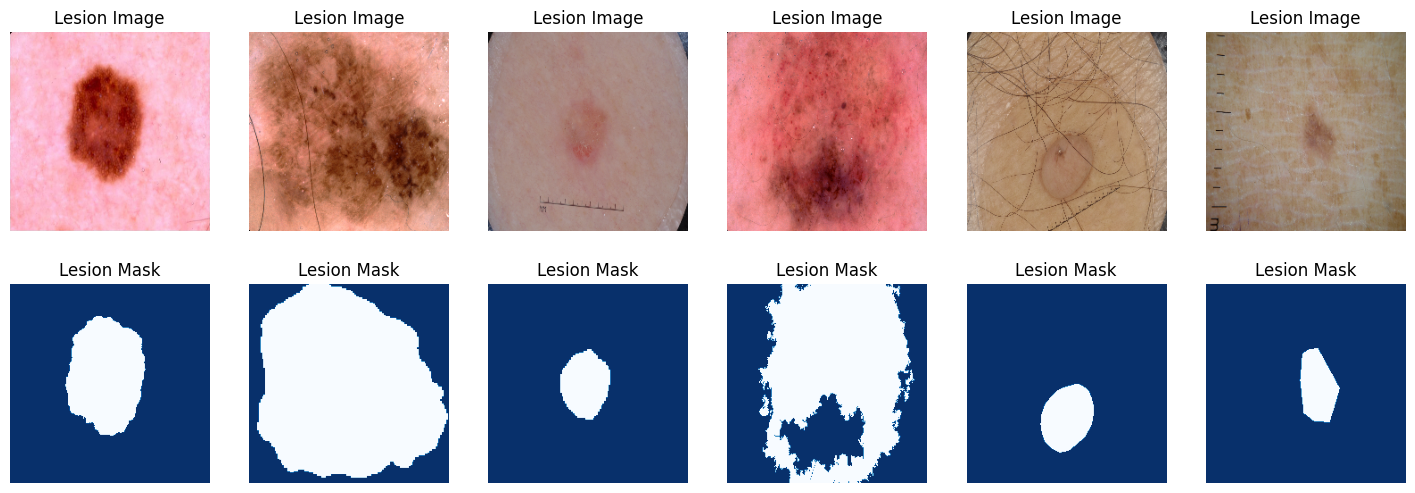

In [6]:
def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def show_subset(images, masks, n):
    images = images.numpy() 
    masks = masks.numpy()
    
    fig, ax = plt.subplots(2, n, figsize=(n*3,6))
    for i in range(n):
        ax[0, i].imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # np.rollaxis(images[i,:,:,:],0,3)) to swap channel axes to channels last
        ax[1, i].imshow(masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[0, i].set_title('Lesion Image')
        ax[1, i].set_title('Lesion Mask')
        ax[1, i].axis('off')
        ax[0, i].axis('off')
    plt.show()

dataiter = iter(valid_loader) # get iterator of train_loader 
images, masks = next(dataiter) # get a random batch of train_loader iterator
show_subset(images, masks, n=6) # show images, masks subset of size n of batch

# 3 Creating the Model

Next, a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) model is created. The variable `MODEL_DIR` specifies the directory where checkpoints of the trained model weights are stored and can be loaded via the variable `MODEL_CHECKPOINTS` when training shoud be resumed.

U-Net models with different CNN backbones can be loaded as U-Net encoders using the `Unet()` function of the [segmentation-models-pytorch 0.2.1](https://github.com/qubvel/segmentation_models.pytorch) package. The used CNN backbone is defined by the parameter `encoder_name`. Additionally the parameter `encoder_weights` can be used to specify if the CNN backbone should be loaded with pre-trained weights (e.g. ImageNet). A list of all possible backbones is available in the GitHub repository. In this example, an EfficientNet-B0 pre-trained with ImageNet is used as the U-Net encoder.

Since the skin images are RGB color images, the number of input channels `in_channels` should be set to 3. The goal of the U-Net model is to automatically create a binary segmentation mask for the skin images, with pixel values 0=background and 1=lesion. Therefore, the number of prediction classes of the output layer `classes` has to be set to 1. 

Using the package `torchinfo` and the function `summary()` the model structure of the U-Net can be clearly displayed. Alternatively, this can also be done with the Python function `print()`.

In [7]:
print("Creating model")
print("model_dir: ", os.path.realpath(MODEL_DIR))
os.makedirs(MODEL_DIR, exist_ok=True)

# Create model
# see https://github.com/qubvel/segmentation_models.pytorch
model = smp.Unet(encoder_name='efficientnet-b0',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=1)

MODEL_CHECKPOINTS = None # Specifying model checkpoints for continuing training, e.g. f"{MODEL_DIR}/model_epoch1.pth"
if MODEL_CHECKPOINTS: # load model checkpoints if available
    model.load_state_dict(torch.load(MODEL_CHECKPOINTS, map_location="cpu"))

print(summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), depth=5))
print(model)

print("Model successfully created")

Creating model
model_dir:  /home/simon.puettmann/segmentation/models/segmentation
Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [16, 1, 224, 224]         --
├─EfficientNetEncoder: 1-1                              [16, 3, 224, 224]         412,160
│    └─Conv2dStaticSamePadding: 2-1                     [16, 32, 112, 112]        864
│    │    └─ZeroPad2d: 3-1                              [16, 3, 225, 225]         --
│    └─BatchNorm2d: 2-2                                 [16, 32, 112, 112]        64
│    └─MemoryEfficientSwish: 2-3                        [16, 32, 112, 112]        --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [16, 16, 112, 112]        --
│    │    │    └─Conv2dStaticSamePadding: 4-1           [16, 32, 112, 112]        288
│    │    │    │    └─ZeroPad2d: 5-1                    

### Loss Function
Machine learning is basically an optimization task that aims to minimize an error between predictions of a model e.g. a neural network and actual observations from a dataset. To quantify the error between model predictions and actual observations, a loss function is required. If the model predictions deviate too much from the actual observations, the loss function takes on a very high value, the so-called loss. The goal of the training process is now to minimize this loss step by step by adjusting the weights of the neural network using optimization algorithms.

In segmentation tasks, the loss between the predicted segmentation mask by the model and the ground truth segmentation mask can be quantified pixel by pixel in different ways. Since the segmentation task is essentially a classification problem for each pixel of the segmentation mask, common loss functions for classification can be used (e.g., cross entropy) and the loss can be evaluated for each pixel individually and then averaged over all pixels. However, this can be a problem if the different pixel proportions of the classes are unbalanced in the image, as the training would be dominated by the most abundant class. Exempt from this problem are loss functions (e.g., the [Dice-Loss](https://arxiv.org/abs/2006.14822)), which essentially quantify the overlap between the segmentation mask of the model prediction and the ground truth.

In [8]:
# Loss functions from segmentation_models.pytorch, see: https://github.com/qubvel/segmentation_models.pytorch

# loss function based on Dice-Score
loss_function = DiceLoss(mode='binary', from_logits=True) 

### Optimizer
Optimizers are optimization algorithms and are responsible for adjusting weights in the training process. PyTorch already implements a number of different [optimizers](https://pytorch.org/docs/stable/optim.html#module-torch.optim) with different optimization methods. We will use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer for our training.

An important parameter of the optimizers is the learning rate, which can be used to adjust the amount of weight adjustment per training step. Common learning rates range from `0.001` to `0.00001`. Larger learning rates allow faster training, but can also lead to problematic jumps in solution space and divergence (consistently bad errors). Smaller learning rates are suitable for fine-tuning.

__Task:__ Replace the variable `LEARN_RATE` with a suitable learning rate. Experiment with different learning rates.

In [9]:
# optimizer 
LEARN_RATE = 1e-05
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)

### Metrics and logs for monitoring the training progress.

In addition to loss, other [metrics](https://de.wikipedia.org/wiki/Beurteilung_eines_bin%C3%A4ren_Klassifikators) can be helpful in evaluating the training progress of a neural network. 

For segmentation, the degree of overlap Intersection-over-Union (IoU) is often used as a measure of segmentation performance. The IoU metric, also called the Jaccard index, quantifies the percentage of overlap between the ground truth segmentation mask and the segmentation mask from the model prediction, or more simply, the number of pixels that the segmentation masks have in common divided by the total number of pixels from both masks.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png" width="300" />
Source: https://en.wikipedia.org/wiki/Jaccard_index


The package [TorchMetric](https://torchmetrics.readthedocs.io/en/stable/) provides a convenient solution to collect different metrics during the training process.

For later visualization of the training process it is useful to log losses and other metrics during the training. In this example, these are stored in the dictonary `logs` during the training.

In [10]:
loss_metric = MeanMetric()
iou_metric = JaccardIndex(task="binary", num_classes=2, threshold=0.5, average='macro') #only wrapper for BinaryJaccardIndex

logs = {'loss': [], 'iou': [], 'val_loss': [], 'val_iou': []}

## 3.2 Model Training

In order for PyTorch to perform training on the GPU, all the important components of the training process, such as the model itself, the loss function, metrics, images and labels from the DataLoader, etc., must be moved to the VRAM of the GPU. This is possible via the function `.to(device)`. `device` is a variable that takes the string "cuda" if a GPU is available, otherwise the string "cpu" and the training does not take place on a GPU.

In [11]:
device = ("cuda" if torch.cuda.is_available() else "cpu") 

# move model, loss and metrics to GPU-VRAM if available
model = model.to(device)
loss_function = loss_function.to(device)
loss_metric = loss_metric.to(device)
iou_metric = iou_metric.to(device)

The actual training takes place subsequently and can take some time. Whether the kernel is still active in the background can be seen by the circle in the upper right corner - as long as the circle is filled, the script is still running.

The training is done epoch by epoch `for epoch in range(NUM_EPOCHS):`, where one training epoch corresponds to the pass of all minibatches of the training dataset. The variable `NUM_EPOCHS` (defined above) can be used to specify the number of training epochs.

A training epoch consists of two phases, the training phase and the validation phase. At the beginning of a training phase, first the model is put into training mode `model.train()` and previously stored metrics are reset `loss_metric.reset()`. Then we iterate over the minibatches of the training dataset `for i, (images, masks) in enumerate(train_loader, 0)`, move the images and masks of the minibatch into the GPU VRAM `images.to(device) ...`, delete previously stored gradient information of the optimizer `optimizer. zero_grad()`, passed the image data of the minibatch to the model for prediction `outputs = model(images)`, determined the loss between the masks of the model prediction and masks of the ground truths of the minibatch `loss_function(y_pred=outputs, y_true=masks)`, backpropagated the loss over the model weights (gradient information is determined) `loss. backward()`, the model weights are adjusted with the optimizer according to the gradient information `optimizer.step()` and metrics for this training step are computed `... iou_of_batch = iou_metric(predictions, masks)`.

When all minibatches in the training dataset have been passed, a training epoch is complete. After the training epoch, the learning rate scheduler `lr_scheduler.step()` is called, which adjusts the learning rate according to the defined strategy for the next training epoch, and the averaged loss `loss_metric.compute() ...` and the averaged metrics for the entire training epoch are computed and stored in `logs`.

Following the training phase, the validation phase begins. In the validation phase, loss and metrics are determined using `unseen` validation data. Important. There is no adjustment of model weights. The validation phase differs only slightly from the previously described training phase. First, the model is put into `model.eval()` validation mode, the metrics from the previous training phase are reset and then we iterate over all the minibatches in the validation dataset, pass the image data to the model for prediction, determine loss and metrics and finally store them in `logs`. 

At the end of each training epoch, the model weights of the current epoch are `torch.save(model.state_dict(), ...)` stored and the computed training/validation loss and metrics are saved to a CSV file.

In [12]:
from codecarbon import EmissionsTracker

NUM_EPOCHS = 15

tracker = EmissionsTracker(measure_power_secs=9999)
tracker.start()
print("Start training")
try:  
    #iterate over epochs
    for epoch in range(NUM_EPOCHS):
        
        # progress bar [optional]
        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=NUM_EPOCHS, width=24, always_stateful=False)
        
        ############################## training phase ####################################
        # set model to training phase
        model.train()
        
        # reset metrics for training phase
        loss_metric.reset()
        iou_metric.reset()
        
        # iterate over training batches 
        for i, (images, masks) in enumerate(train_loader, 0):
            # move training batch with labels to GPU-VRAM 
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
    
            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)
    
            # forward pass
            outputs = model(images).squeeze(dim=1)
            loss = loss_function(y_pred=outputs, y_true=masks)
            
            # backward pass 
            loss.backward()
            optimizer.step()
            
            # update running metrics
            loss_of_batch = loss_metric(loss)
            predictions = torch.sigmoid(outputs)
            iou_of_batch = iou_metric(predictions, masks)
    
            # Update progress bar [optional]
            kbar.update(i, values=[("loss", loss_of_batch), ("IoU", iou_of_batch)])
        
        # learning rate scheduler step 
        #lr_scheduler.step()
        
        # calculate training metric results for the epoch and append results to logs
        epoch_loss = loss_metric.compute().detach().cpu().item()
        epoch_iou = iou_metric.compute().detach().cpu().item()
        logs['loss'].append(epoch_loss)
        logs['iou'].append(epoch_iou)
        
              
        ############################## validation phase ####################################
        # set model to validation phase
        model.eval()
        
        # reset metrics for validation phase
        loss_metric.reset()
        iou_metric.reset()
        
        # prevents PyTorch from gathering gradients to speed up validation phase
        with torch.no_grad():
            # iterate over validation batches 
            for i, (images, masks) in enumerate(valid_loader, 0):
                # move validation batch with labels to GPU-VRAM 
                images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
    
                # forward pass
                outputs = model(images).squeeze(dim=1)
                loss = loss_function(y_pred=outputs, y_true=masks)
    
                # update running metrics
                loss_of_batch = loss_metric(loss)
                predictions = torch.sigmoid(outputs)
                iou_of_batch = iou_metric(predictions, masks)
    
            # calculate validation metric results for the epoch and append results to logs
            epoch_val_loss = loss_metric.compute().detach().cpu().item()
            epoch_val_iou = iou_metric.compute().detach().cpu().item()
            logs['val_loss'].append(epoch_val_loss)
            logs['val_iou'].append(epoch_val_iou)
            
            # Add validation results to progress bar [optional]
            kbar.add(1, values=[("val_loss", epoch_val_loss), ("val_IoU", epoch_val_iou)])
            
        ############################## save epoch results ############################ 
        #save model weights for the epoch
        torch.save(model.state_dict(), f'{MODEL_DIR}/model_epoch{epoch}.pth')
        
        # save logs for the epoch as csv
        logs_as_df = pd.DataFrame(logs)
        logs_as_df.to_csv(f'{MODEL_DIR}/training_history.csv', index_label='epoch', sep=',', encoding='utf-8')
finally:
    emissions = tracker.stop()   
    
print(f"Finished training, model saved to: {MODEL_DIR}/model_epoch{epoch}.pth")
print(f"{emissions * 1_000}g CO2 produced")

[codecarbon INFO @ 08:52:41] [setup] RAM Tracking...
[codecarbon INFO @ 08:52:41] [setup] GPU Tracking...
[codecarbon INFO @ 08:52:41] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:52:41] [setup] CPU Tracking...
[codecarbon WARNING @ 08:52:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 08:52:42] We saw that you have a Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 08:52:42] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
[codecarbon INFO @ 08:52:42] >>> Tracker's metadata:
[codecarbon INFO @ 08:52:42]   Platform system: Linux-5.4.0-174-generic-x86_64-with-glibc2.27
[codecarbon INFO @ 08:52:42]   Python version: 3.10.9
[codecarbon INFO @ 08:52:42]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 08:52:42]   Available RAM : 503.767 GB
[codecarbon INFO @ 08:52:42]   CPU count: 80
[codecarbon INFO @ 08:52:42]   CPU model: Intel(R) Xeon(R) CPU E5-2698 v4 @ 

Start training
Epoch: 1/15
130/130 [========================] - 756s 6s/step - loss: 0.6822 - IoU: 0.2150 - val_loss: 0.6574 - val_IoU: 0.2516
Epoch: 2/15
130/130 [========================] - 286s 2s/step - loss: 0.6313 - IoU: 0.2818 - val_loss: 0.5886 - val_IoU: 0.3313
Epoch: 3/15
130/130 [========================] - 244s 2s/step - loss: 0.5743 - IoU: 0.3664 - val_loss: 0.5380 - val_IoU: 0.4345
Epoch: 4/15
130/130 [========================] - 172s 1s/step - loss: 0.5306 - IoU: 0.4519 - val_loss: 0.4922 - val_IoU: 0.5312
Epoch: 5/15
130/130 [========================] - 154s 1s/step - loss: 0.4978 - IoU: 0.5225 - val_loss: 0.4545 - val_IoU: 0.5917
Epoch: 6/15
130/130 [========================] - 149s 1s/step - loss: 0.4705 - IoU: 0.5750 - val_loss: 0.4331 - val_IoU: 0.6276
Epoch: 7/15
130/130 [========================] - 153s 1s/step - loss: 0.4496 - IoU: 0.6073 - val_loss: 0.4089 - val_IoU: 0.6562
Epoch: 8/15
130/130 [========================] - 148s 1s/step - loss: 0.4301 - IoU: 0.630

[codecarbon INFO @ 09:44:51] Energy consumed for RAM : 0.164044 kWh. RAM Power : 188.91272735595703 W
[codecarbon INFO @ 09:44:51] Energy consumed for all GPUs : 0.064802 kWh. Total GPU Power : 74.62589211954653 W
[codecarbon INFO @ 09:44:51] Energy consumed for all CPUs : 0.036905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:44:51] 0.265752 kWh of electricity used since the beginning.


Finished training, model saved to: /home/simon.puettmann/segmentation/models/segmentation//model_epoch14.pth
102.41793934805442g CO2 produced


/home/simon.puettmann/.local/lib/python3.10/site-packages/codecarbon/output.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])


The output of the training script contains the following information:

- `1/130`: The currently processed minibatch.
- `ETA:`: Expected time remaining of a training epoch
- `417s 181ms/step`: Total duration of the training epoch as well as the average duration of a training step
- `loss:`: Average loss of all/ already processed minibatches of the training data
- `IoU:`: Average IoU of all/ already processed minibatches of the training data
- `val_loss:`: Mean loss of all minibatches of validation data (generated only once per epoch)
- `val_IoU:`: mean value of the IoU of all minibatches of the validation data (generated only once per epoch)

It is important to compare the values of the training and validation data. If these values are far apart, there is an overfitting, i.e. the training data is memorized.

<a id='visualization'></a>
## 3.3 Visualization of the Training

Using the stored losses and other metrics of the training and validation data in the dictonary `logs`, the training process can be visualized afterwards.

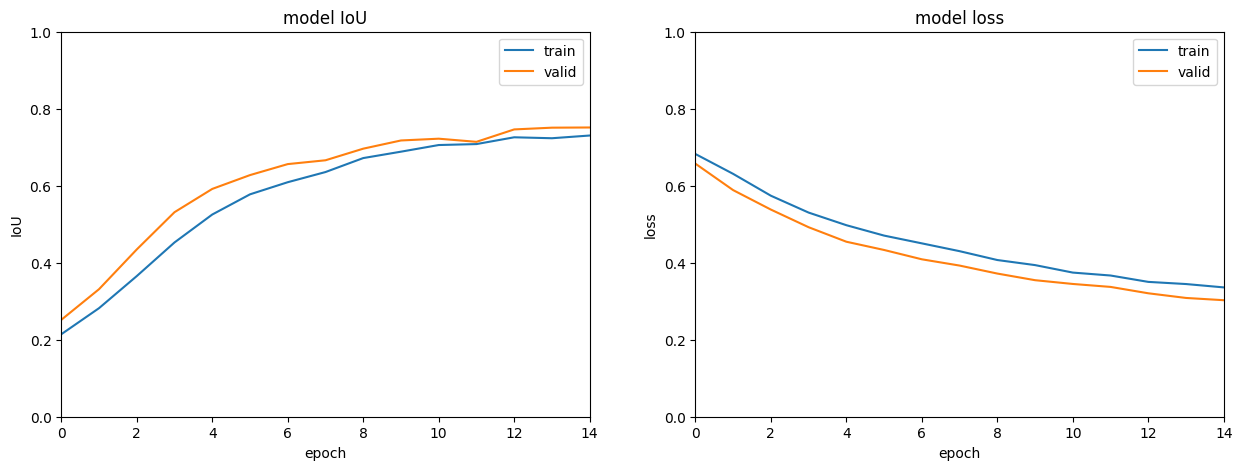

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# plot training history for accuracy
ax[0].plot(logs['iou'], label='train')
ax[0].plot(logs['val_iou'], label='valid')
ax[0].set_title('model IoU')
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, NUM_EPOCHS-1)
ax[0].set_ylabel('IoU')
ax[0].set_xlabel('epoch')
ax[0].legend(loc='best')

# plot training history for loss
ax[1].plot(logs['loss'], label='train')
ax[1].plot(logs['val_loss'], label='valid')
ax[1].set_title('model loss')
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, NUM_EPOCHS-1)
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='best')

fig.savefig(f'{MODEL_DIR}/training_history.png', dpi=100, format="png")
plt.show()

## 4 Model Evaluation

During the model evaluation, we want to check which segmentation performance our trained model achieves on unseen test data.

### Test Dataset

For simplicity, the validation data is used as test data in the following. __Important!__ This procedure is not optimal because our validation data is no longer independent due to parameter tuning of the learning rate or similar and theoretically overfitting on the validation data can occur. 
In order for the evaluation of the segmentation performance of the model to remain meaningful, a small subset of the data set should be retained as independent test data prior to model training and parameter tuning. 

Loading and preprocessing of the test data can be done in the same way as in section 2.

In [14]:
# albumentation pre-processing pipeline for the test images 
test_transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

# create test dataset and loader
test_dataset = ISIC2018Task1_Dataset(valid_image_files, valid_mask_files, test_transform)
test_loader = DataLoader(dataset=test_dataset, 
                          shuffle=True, # shuffle only for visualization purposes else set to False  
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)

print(f'Found {len(valid_dataset)} test images')

Found 519 test images


### Inference
Inference is the process of using a trained model to make predictions for previously unseen data. To interpret the predicted segmentation mask of the model, the respective pixel-wise activations of the output neurons are converted into prediction probabilities of the interval [0,1] using sigmod activation (binary case). Then, on a pixel-by-pixel basis, the prediction probabilities of the segmentation mask are used to decide whether a pixel < 0.5 belongs to the "background" class or > 0.5 to the "lesion" class. 

Subsequently, to determine the segmentation performance of the model, various metrics (IoU, Recall, Precision) and a confusion matrix are computed for the segmentation masks of the model predictions compared to the ground truths.

In [15]:
# test metrics for evaluating the classification performance of the model 
test_iou_metric = JaccardIndex(task="binary", num_classes=2, threshold=0.5, average='macro').to(device)
test_recall_metric = Recall(task="binary", num_classes=2, average=None, multidim_average='global').to(device)
test_precision_metric = Precision(task="binary", num_classes=2, average=None, multidim_average='global').to(device)
confusion_matrix_metric = ConfusionMatrix(task="binary", num_classes=2, normalize='true', threshold=0.5).to(device)

# iterate over testdata batches (tqdm only for progress bar)
for (images, masks) in tqdm.tqdm(test_loader):
    # transfer images to the GPU for model inference
    images, masks = images.to(device), masks.to(device) 

    # model inference for each image in the batch 
    outputs = model(images).squeeze(dim=1)
    prediction_probabilities = torch.sigmoid(outputs) # compute the model prediction probabilities from logit outputs for all classes
    prediction_masks = (prediction_probabilities > 0.5).int() # threshold prediction probabilities: if > 0.5 class 1 (lesion) else class 0 (background)
    
    # update running test metrics
    test_iou_metric.update(prediction_masks, masks)
    test_recall_metric.update(prediction_masks, masks)
    test_precision_metric.update(prediction_masks, masks)
    confusion_matrix_metric.update(prediction_masks, masks)
    
# calculate test metric results
test_iou = test_iou_metric.compute().detach().cpu().item()
test_recall = test_recall_metric.compute().detach().cpu().numpy()
test_precision = test_precision_metric.compute().detach().cpu().numpy()
test_confusion_matrix = confusion_matrix_metric.compute().detach().cpu().numpy()

print(test_recall)

print(f"Testdata evaluation results:\nIoU: {test_iou:.5f}\n{pd.DataFrame({'Recall': test_recall, 'Precision': test_precision}, index = ['background', 'lesion'])}")

100%|████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.01s/it]

0.9497915
Testdata evaluation results:
IoU: 0.75127
              Recall  Precision
background  0.949791   0.782341
lesion      0.949791   0.782341


### Confusion Matrix
A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is also helpful for interpreting the segmentation performance of a model. It can be used to determine which classes of the data set are frequently segmented correctly or incorrectly by the model as well as which classes are most frequently confused.

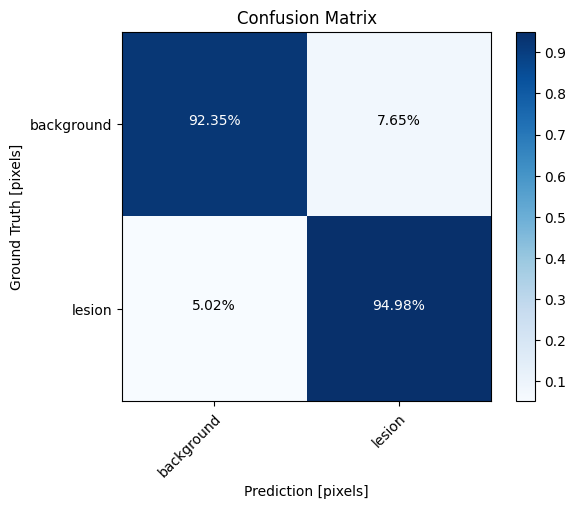

In [16]:
# confusion matrix computed earlier
cm = test_confusion_matrix
#print(f"confusion matrix:\n{cm}")

# plot confusion matrix
fig, ax = plt.subplots(1,1)
cm_fig = ax.imshow(cm, interpolation='nearest', cmap="Blues") # plot confusion matrix background color 
fig.colorbar(cm_fig, ax=ax) # add confusion matrix color bar
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['background', 'lesion'], rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(['background', 'lesion'])
ax.set_xlabel('Prediction [pixels]')
ax.set_ylabel('Ground Truth [pixels]') 
ax.set_title("Confusion Matrix")

# plot confusion matrix values
for ix, iy in np.ndindex(cm.shape):
    ax.text(iy, ix, f"{100*cm[ix, iy]:.2f}%", horizontalalignment="center", color="white" if cm[ix, iy] > cm.max() / 2.0 else "black")
    #ax.text(iy, ix, cm[ix, iy], horizontalalignment="center", color="white" if cm[ix, iy] > cm.max() / 2.0 else "black")    


fig.savefig(f'{MODEL_DIR}/confusion_matrix.png', dpi=100, format="png")
plt.show()    

### Inference with Visualization
Next is inference for a minibatch of the test data, followed by visualization of the masks ground truths and model predictions for each image of the minibatch.

This cell can be executed multiple times to display the result of a random batch of the test data.

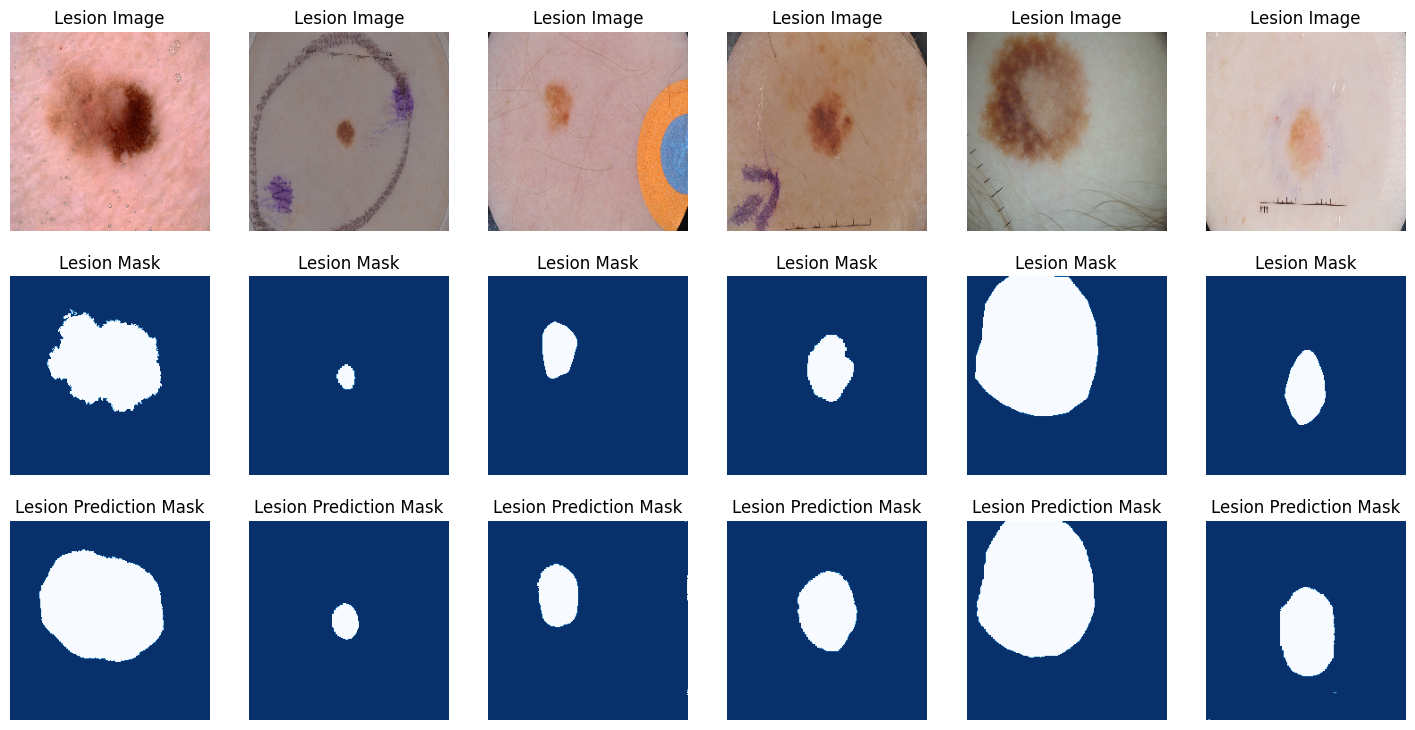

In [17]:
def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def show_predictions(images, masks, prediction_masks, n=6):
    images = images.cpu().numpy() 
    masks = masks.cpu().numpy()
    prediction_masks = prediction_masks.cpu().numpy()
    
    fig, ax = plt.subplots(3, n, figsize=(n*3,9))
    for i in range(n):
        ax[0, i].imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # np.rollaxis(images[i,:,:,:],0,3)) to swap channel axes to channels last
        ax[1, i].imshow(masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[2, i].imshow(prediction_masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[0, i].set_title('Lesion Image')
        ax[1, i].set_title('Lesion Mask')
        ax[2, i].set_title('Lesion Prediction Mask')
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')
    plt.show()

dataiter = iter(test_loader) # get iterator of test_loader 
images, masks = next(dataiter) # get a random batch of test_loader iterator

# transfer images to the GPU for model inference
images = images.to(device) 

# model inference for each image in the batch 
outputs = model(images) 
prediction_probabilities = torch.sigmoid(outputs) # compute the model prediction probabilities from logit outputs for all classes
prediction_masks = (prediction_probabilities > 0.5).float().squeeze(1) # threshold prediction probabilities: if > 0.5 class 1 (lesion) else class 0 (background)

show_predictions(images, masks, prediction_masks, n=6) # show n images, masks, predictions of batch